In [1]:
%cd ../..

/home/dmoreno/ATAT_ZTF/elasticc_one


# Confusion matrices

In [2]:
import os
import json 
import torch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#from utils import get_y_test_pred_folds, get_confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_data = './data/final/ZTF_ff/LC_MD_FEAT_v2_windows_99'
path_results = './results/ZTF/LC_MD_FEAT/elasticc_to_ztf_tm_99_1e-4/MTA'
time_to_eval = 2048

order_classes = ['SNIa', 
                 'SNIbc', 
                 'SNIIb', 
                 'SNII', 
                 'SNIIn', 
                 'SLSN', 
                 'TDE', 
                 'Microlensing', 
                 'QSO', 
                 'AGN', 
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', 
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [6]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{5: 'AGN', 15: 'Blazar', 11: 'CEP', 14: 'CV/Nova', 1: 'DSCT', 12: 'EA', 2: 'EB/EW', 7: 'LPV', 21: 'Microlensing', 13: 'Periodic-Other', 3: 'QSO', 10: 'RRLab', 8: 'RRLc', 4: 'RSCVn', 18: 'SLSN', 19: 'SNII', 16: 'SNIIb', 0: 'SNIIn', 6: 'SNIa', 20: 'SNIbc', 17: 'TDE', 9: 'YSO'}


In [7]:
predictions = torch.load('{}/predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaagryq_0', b'ZTF17aaagryq_1', b'ZTF17aaagryq_2', ...,
        b'ZTF23aamsarj_2', b'ZTF23aamsarj_3', b'ZTF23aamsarj_4'],
       dtype=object),
 'y_test': tensor([ 9,  9,  9,  ..., 19, 19, 19]),
 'list_y_pred': {'test_16': array([ 9,  9,  9, ..., 16, 16, 16]),
  'test_32': array([ 9,  9,  9, ..., 19, 16, 19]),
  'test_64': array([ 9,  9,  9, ..., 19, 19, 20]),
  'test_128': array([ 9,  9,  9, ..., 19, 19, 19]),
  'test_256': array([ 9,  9,  9, ..., 19, 19, 19]),
  'test_512': array([ 9,  9,  9, ..., 19, 19, 19]),
  'test_1024': array([ 9,  9,  9, ..., 19, 19, 19]),
  'test_2048': array([ 9,  9,  9, ..., 19, 19, 19])},
 'list_y_pred_prob': {'test_16': array([[1.4022230e-06, 1.1397869e-03, 3.3653996e-04, ..., 1.1167844e-07,
          2.4723917e-08, 2.2098448e-10],
         [9.9130489e-08, 5.4479775e-04, 5.2624091e-05, ..., 2.1345484e-08,
          1.7494624e-09, 2.0633953e-10],
         [4.0546030e-07, 1.3465754e-03, 6.6645924e-05, ..., 5.9979207e-08,
          7.58

In [8]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = [i for i, snid in enumerate(snids_str) if snid.endswith("_0")]

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
print(idx_windows_objects)
print('length: ', len(idx_unique_y_test))
print(idx_unique_y_test)

length:  8350
[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], [27, 28, 29, 30, 31, 32, 33, 34, 35], [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [48, 49, 50, 51, 52, 53, 54, 55], [56, 57, 58, 59, 60, 61, 62, 63, 64], [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85], [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126], [127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141], [142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153], [154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167], [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184], [185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197], [198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210], [211, 21

In [9]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = []
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([ 9, 11, 12, ...,  6,  0, 16]),
 'test_32': array([ 9,  4, 12, ...,  6, 20, 16]),
 'test_64': array([ 9,  4, 12, ...,  6,  6, 19]),
 'test_128': array([ 9,  4, 12, ...,  6,  6, 19]),
 'test_256': array([ 9, 11,  2, ...,  6,  6, 19]),
 'test_512': array([ 9, 11,  2, ...,  6,  6, 19]),
 'test_1024': array([ 9,  4, 12, ...,  6,  6, 19]),
 'test_2048': array([ 9, 11, 12, ...,  6,  6, 19])}

In [10]:
predictions['y_test_unique'] = predictions['y_test'][idx_unique_y_test]
predictions['y_test_unique'].shape

torch.Size([8350])

In [11]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg', 'y_test_unique'])

In [12]:
y_test_label = predictions['y_test_unique']
y_pred_label = predictions['list_y_pred_avg']['test_2048']

y_test_label = [mapping_classes_inverted[x] for x in y_test_label.numpy()]
y_pred_label = [mapping_classes_inverted[x] for x in y_pred_label]

In [13]:
y_test_label

['YSO',
 'CEP',
 'EA',
 'CV/Nova',
 'EA',
 'CEP',
 'CEP',
 'EB/EW',
 'EB/EW',
 'EB/EW',
 'EB/EW',
 'EB/EW',
 'RRLab',
 'DSCT',
 'DSCT',
 'EB/EW',
 'Blazar',
 'AGN',
 'QSO',
 'RRLab',
 'Blazar',
 'RRLab',
 'EB/EW',
 'LPV',
 'CV/Nova',
 'EA',
 'LPV',
 'LPV',
 'RRLab',
 'EA',
 'EB/EW',
 'RRLc',
 'LPV',
 'LPV',
 'RRLab',
 'EA',
 'CV/Nova',
 'CV/Nova',
 'YSO',
 'RRLc',
 'DSCT',
 'RRLc',
 'EA',
 'LPV',
 'EA',
 'EA',
 'LPV',
 'AGN',
 'RRLab',
 'YSO',
 'RRLc',
 'YSO',
 'Periodic-Other',
 'DSCT',
 'AGN',
 'Blazar',
 'RRLc',
 'AGN',
 'RSCVn',
 'CV/Nova',
 'EA',
 'AGN',
 'AGN',
 'RRLc',
 'RSCVn',
 'RRLab',
 'QSO',
 'RRLab',
 'Periodic-Other',
 'LPV',
 'TDE',
 'RSCVn',
 'Blazar',
 'DSCT',
 'SNII',
 'QSO',
 'QSO',
 'CEP',
 'RSCVn',
 'SNIa',
 'SNII',
 'SNII',
 'Periodic-Other',
 'SNIa',
 'SNII',
 'SNIbc',
 'YSO',
 'SNII',
 'RSCVn',
 'AGN',
 'RRLc',
 'SNIa',
 'SNIbc',
 'SNIa',
 'SNII',
 'SNII',
 'SNIa',
 'EA',
 'EA',
 'RRLc',
 'CEP',
 'RRLab',
 'RRLc',
 'EA',
 'EA',
 'DSCT',
 'SNIbc',
 'Blazar',
 'QS

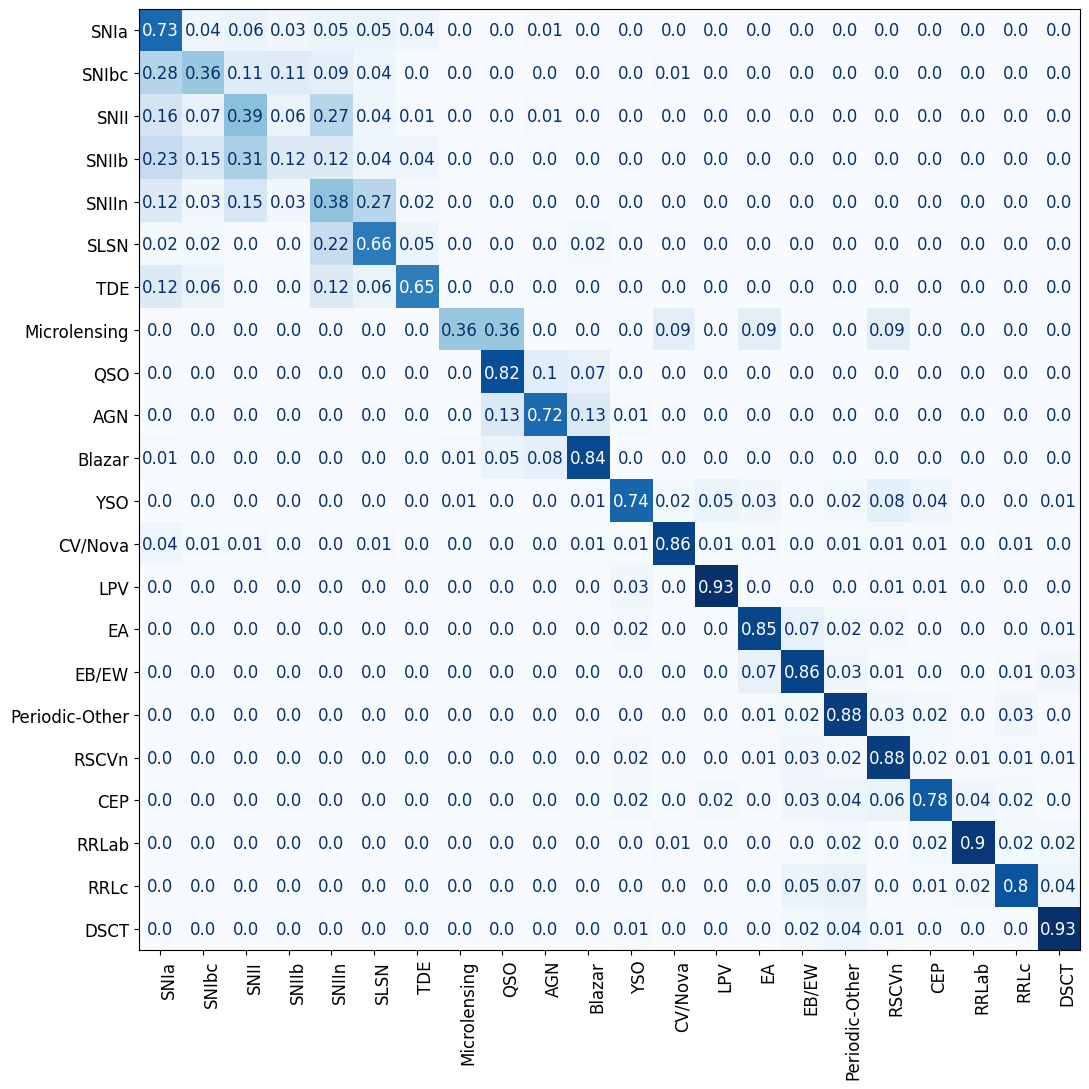

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

## ATAT (LC + MD + Features + MTA) 

In [ ]:
with open('final_dataset/dict_classes.json') as f:
   dict_classes = json.load(f)

print(dict_classes)
dict_classes = {v: k for k, v in dict_classes.items()}

#path_exp = 'results_paper/lc/Exp_cfg_-arch=lc_mtime'
path_exp = 'results_paper/lc_tab/Exp_cfg_-arch=lc_header_feat_mtime'
folds = [0, 1, 2, 3, 4]

list_pred_folds = get_y_test_pred_folds(path_exp, dict_classes, folds)

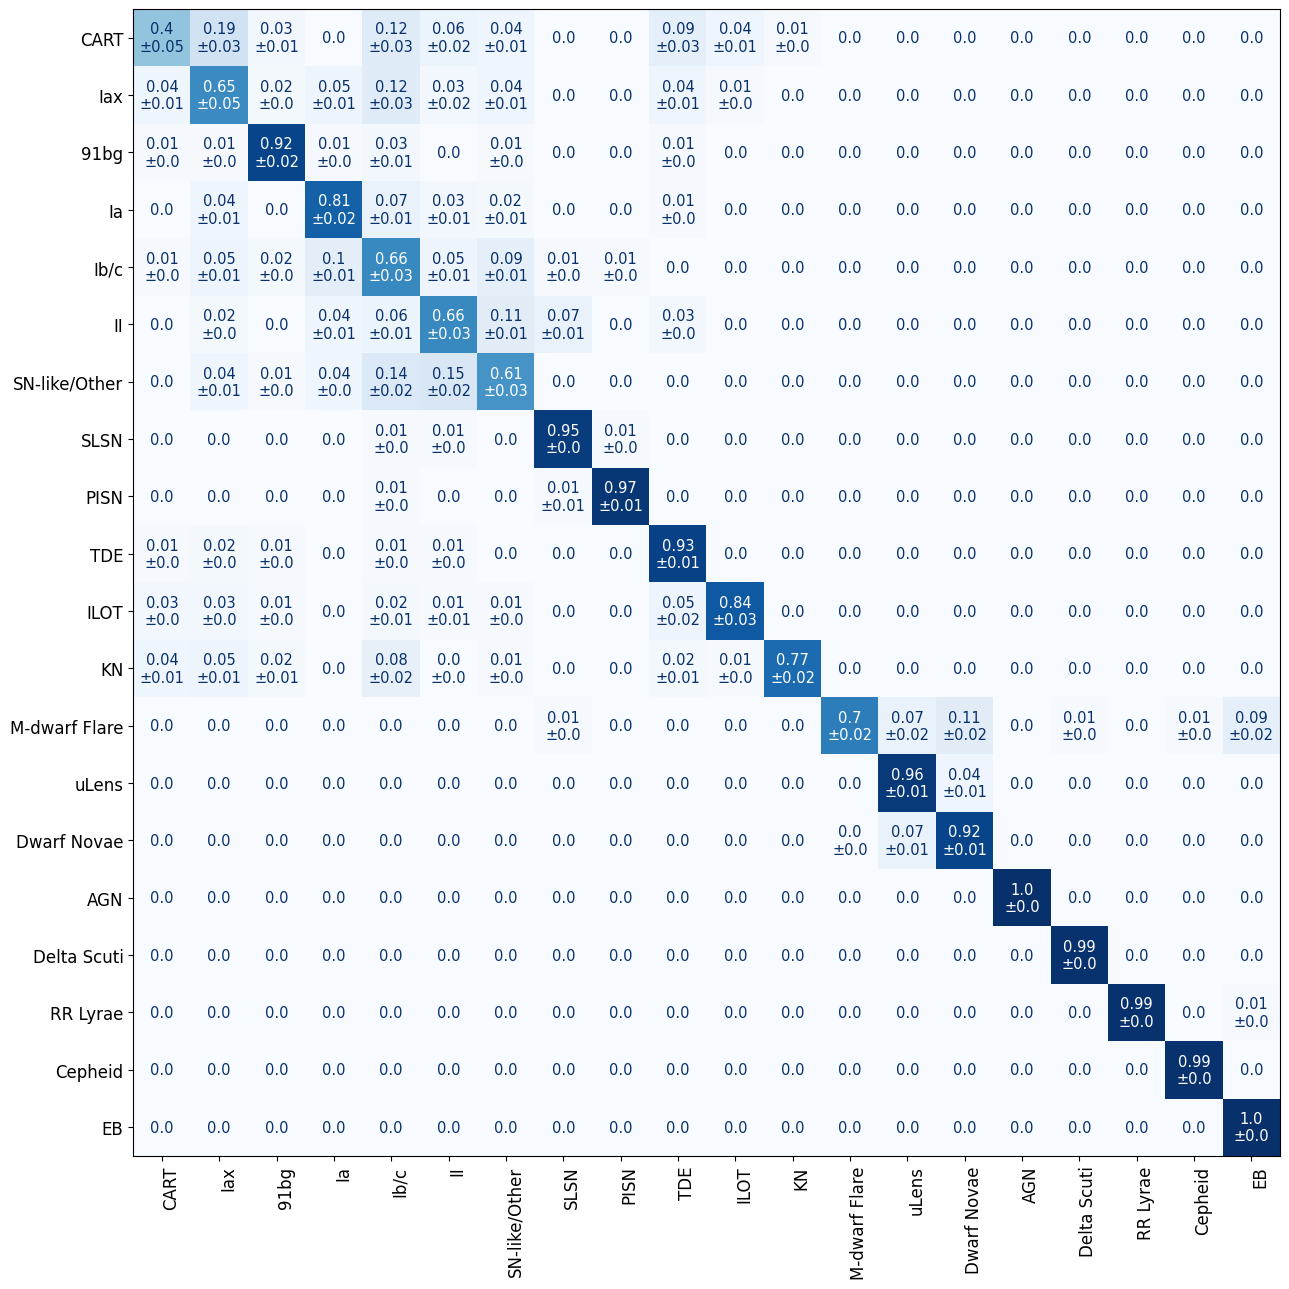

In [49]:
# Suponiendo que tienes y_test_label1, y_pred_label1, y_test_label2, y_pred_label2, etc.
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_lc_md_feat = np.mean(matrices, axis=0)
std_matrix_lc_md_feat = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_lc_md_feat, std_matrix_lc_md_feat, order_classes)

## ATAT (LC + MD + MTA) 

In [52]:
#path_exp = 'results_paper/lc/Exp_cfg_-arch=lc_mtime'
path_exp = 'results_paper/lc_tab/Exp_cfg_-arch=lc_header_mtime'
folds = [0, 1, 2, 3, 4]

list_pred_folds = get_y_test_pred_folds(path_exp, dict_classes, folds)

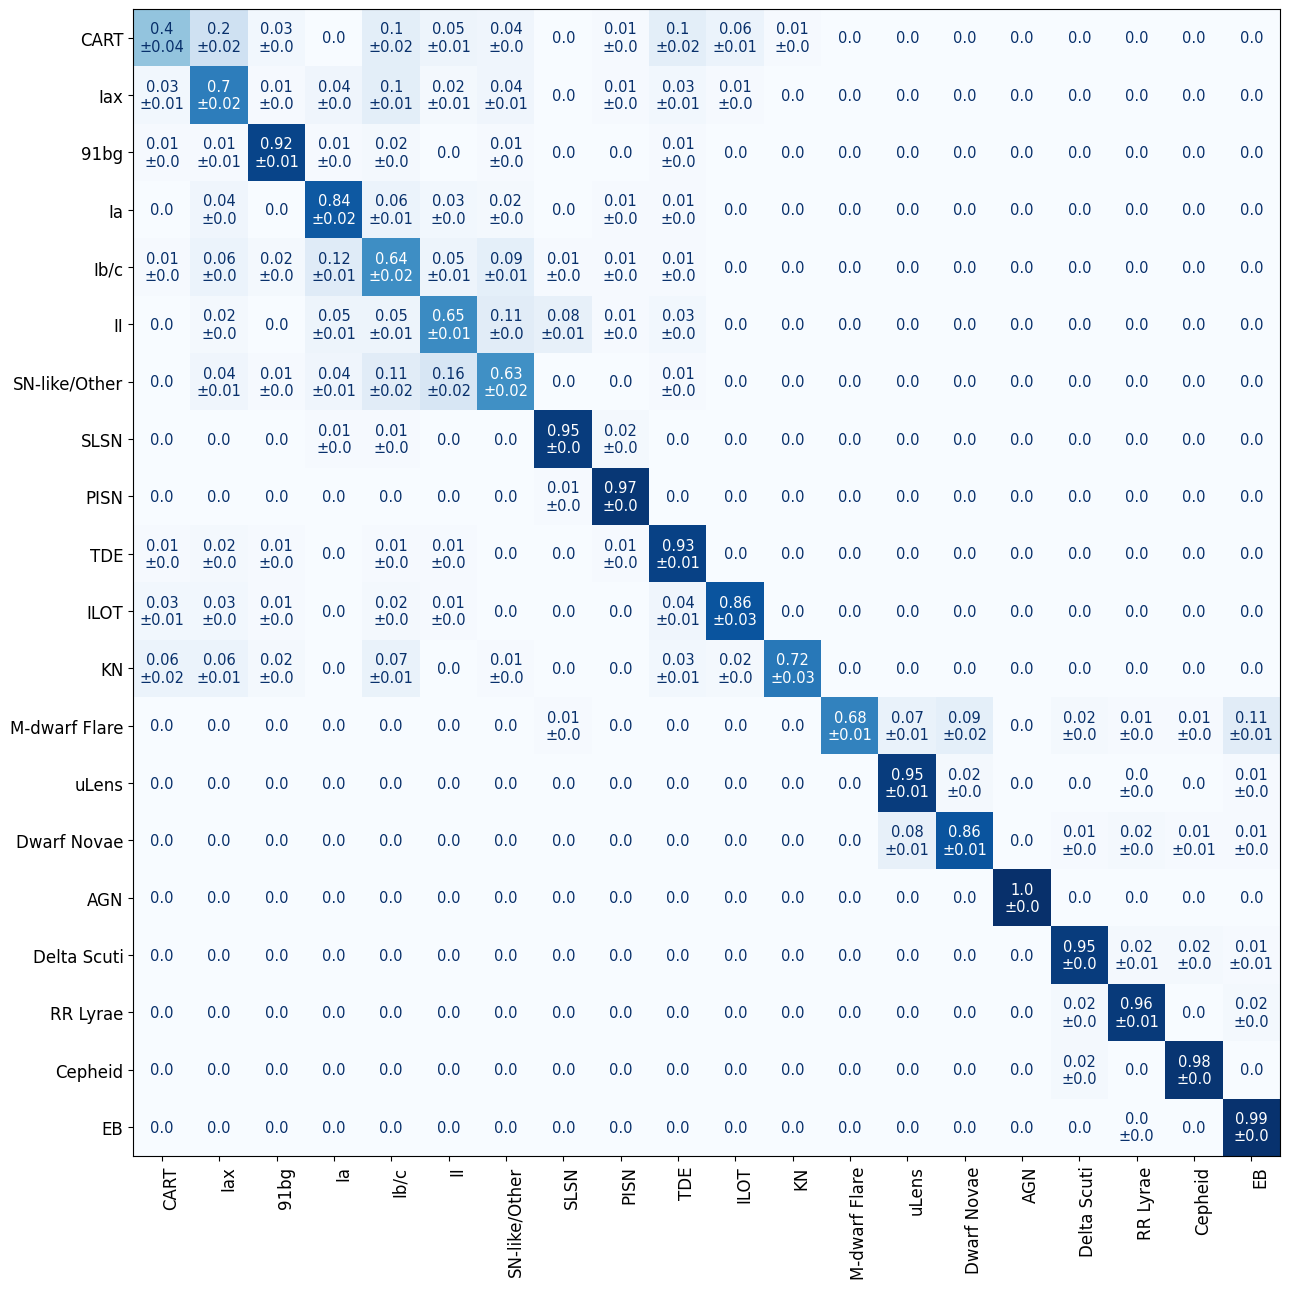

In [53]:
# Suponiendo que tienes y_test_label1, y_pred_label1, y_test_label2, y_pred_label2, etc.
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_lc_md = np.mean(matrices, axis=0)
std_matrix_lc_md = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_lc_md, std_matrix_lc_md, order_classes)

## Random Forest

In [54]:
import pandas as pd

path_root = 'results_rf_paper/2048_days'

In [55]:
test_proba_model = []
num_fold = 5

for i_fold in range(num_fold):
    test_proba_model.append(pd.read_parquet('./{}/test_predictions_proba_model_{}.parquet'.format(path_root, i_fold)))

    for idx_row in range(test_proba_model[i_fold].shape[0]):
        idx_col = test_proba_model[i_fold].iloc[idx_row].argmax()
        test_proba_model[i_fold].iloc[idx_row][idx_col] = 1

    test_proba_model[i_fold][test_proba_model[i_fold] != 1] = 0
    test_proba_model[i_fold] = test_proba_model[i_fold][order_classes]

display(test_proba_model[0].head())
display(test_proba_model[1].head())
print(test_proba_model[0].shape)

,CART,Iax,91bg,Ia,Ib/c,II,SN-like/Other,SLSN,PISN,TDE,ILOT,KN,M-dwarf Flare,uLens,Dwarf Novae,AGN,Delta Scuti,RR Lyrae,Cepheid,EB
SNID,,,,,,,,,,,,,,,,,,,,
63769469_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66380842_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64815643_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52486614_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34971786_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,CART,Iax,91bg,Ia,Ib/c,II,SN-like/Other,SLSN,PISN,TDE,ILOT,KN,M-dwarf Flare,uLens,Dwarf Novae,AGN,Delta Scuti,RR Lyrae,Cepheid,EB
SNID,,,,,,,,,,,,,,,,,,,,
63769469_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66380842_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64815643_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52486614_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34971786_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(20000, 20)


In [56]:
test_set = pd.read_parquet('./data_partition_paper/partitions.parquet')
test_set = test_set[test_set.partition == 'test'].drop(['partition'], axis=1)
test_set['SNID'] = test_set['SNID'].apply(lambda row: row+'_2048')
test_set = test_set.set_index('SNID')
test_set = pd.get_dummies(test_set.label, dtype=float)
test_set = test_set[order_classes]
test_set

,CART,Iax,91bg,Ia,Ib/c,II,SN-like/Other,SLSN,PISN,TDE,ILOT,KN,M-dwarf Flare,uLens,Dwarf Novae,AGN,Delta Scuti,RR Lyrae,Cepheid,EB
SNID,,,,,,,,,,,,,,,,,,,,
63769469_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66380842_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64815643_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52486614_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34971786_2048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34694580_2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
42840389_2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28545440_2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
list_pred_folds = []
for i_fold in folds:
    y_test = np.argmax(test_set.reindex(test_proba_model[i_fold].index).values, axis=1)
    y_pred = np.argmax(test_proba_model[i_fold].values, axis=1)

    y_test_label = [dict_classes[x] for x in y_test]
    y_pred_label = [dict_classes[x] for x in y_pred]

    list_pred_folds.append((y_test_label, y_pred_label))
    

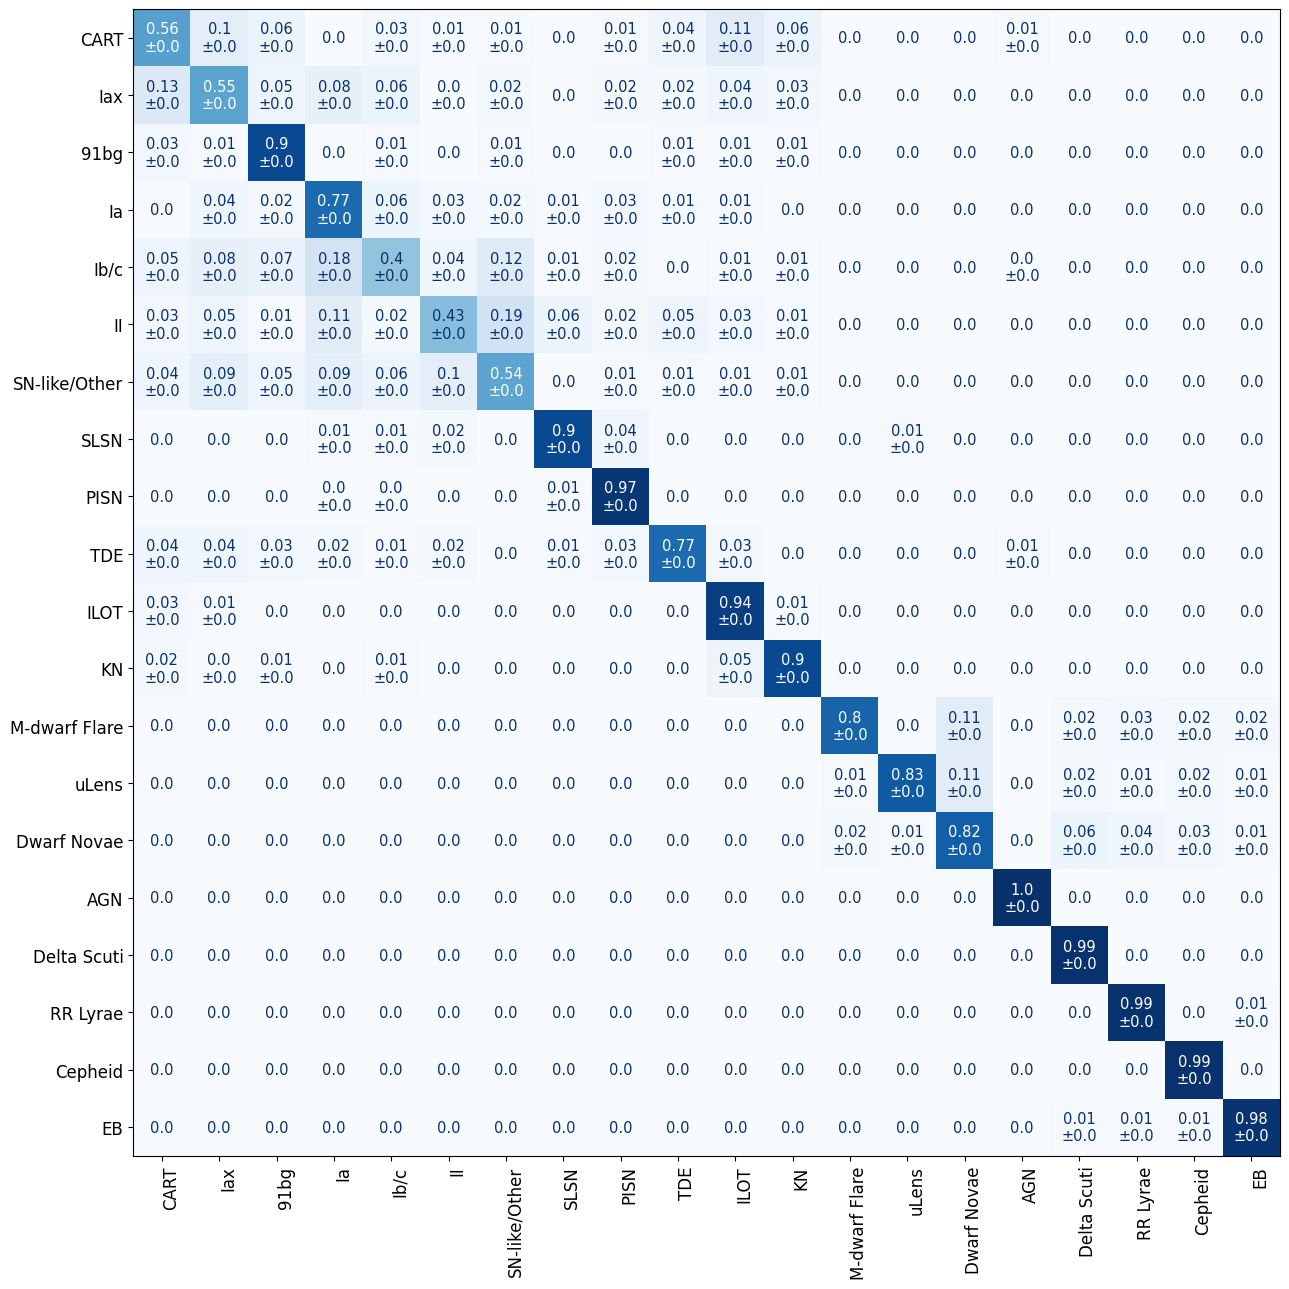

In [58]:
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(np.argmax(test_set.reindex(test_proba_model[i_fold].index).values, axis=1), 
                          np.argmax(test_proba_model[i_fold].values, axis=1), 
                          normalize='true')
    #cm = confusion_matrix(test_set.reindex(test_proba_model[i_fold].index).values, test_proba_model[i_fold].values, normalize='pred')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_rf = np.mean(matrices, axis=0)
std_matrix_rf = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_rf, std_matrix_rf, order_classes)

## Joint plot

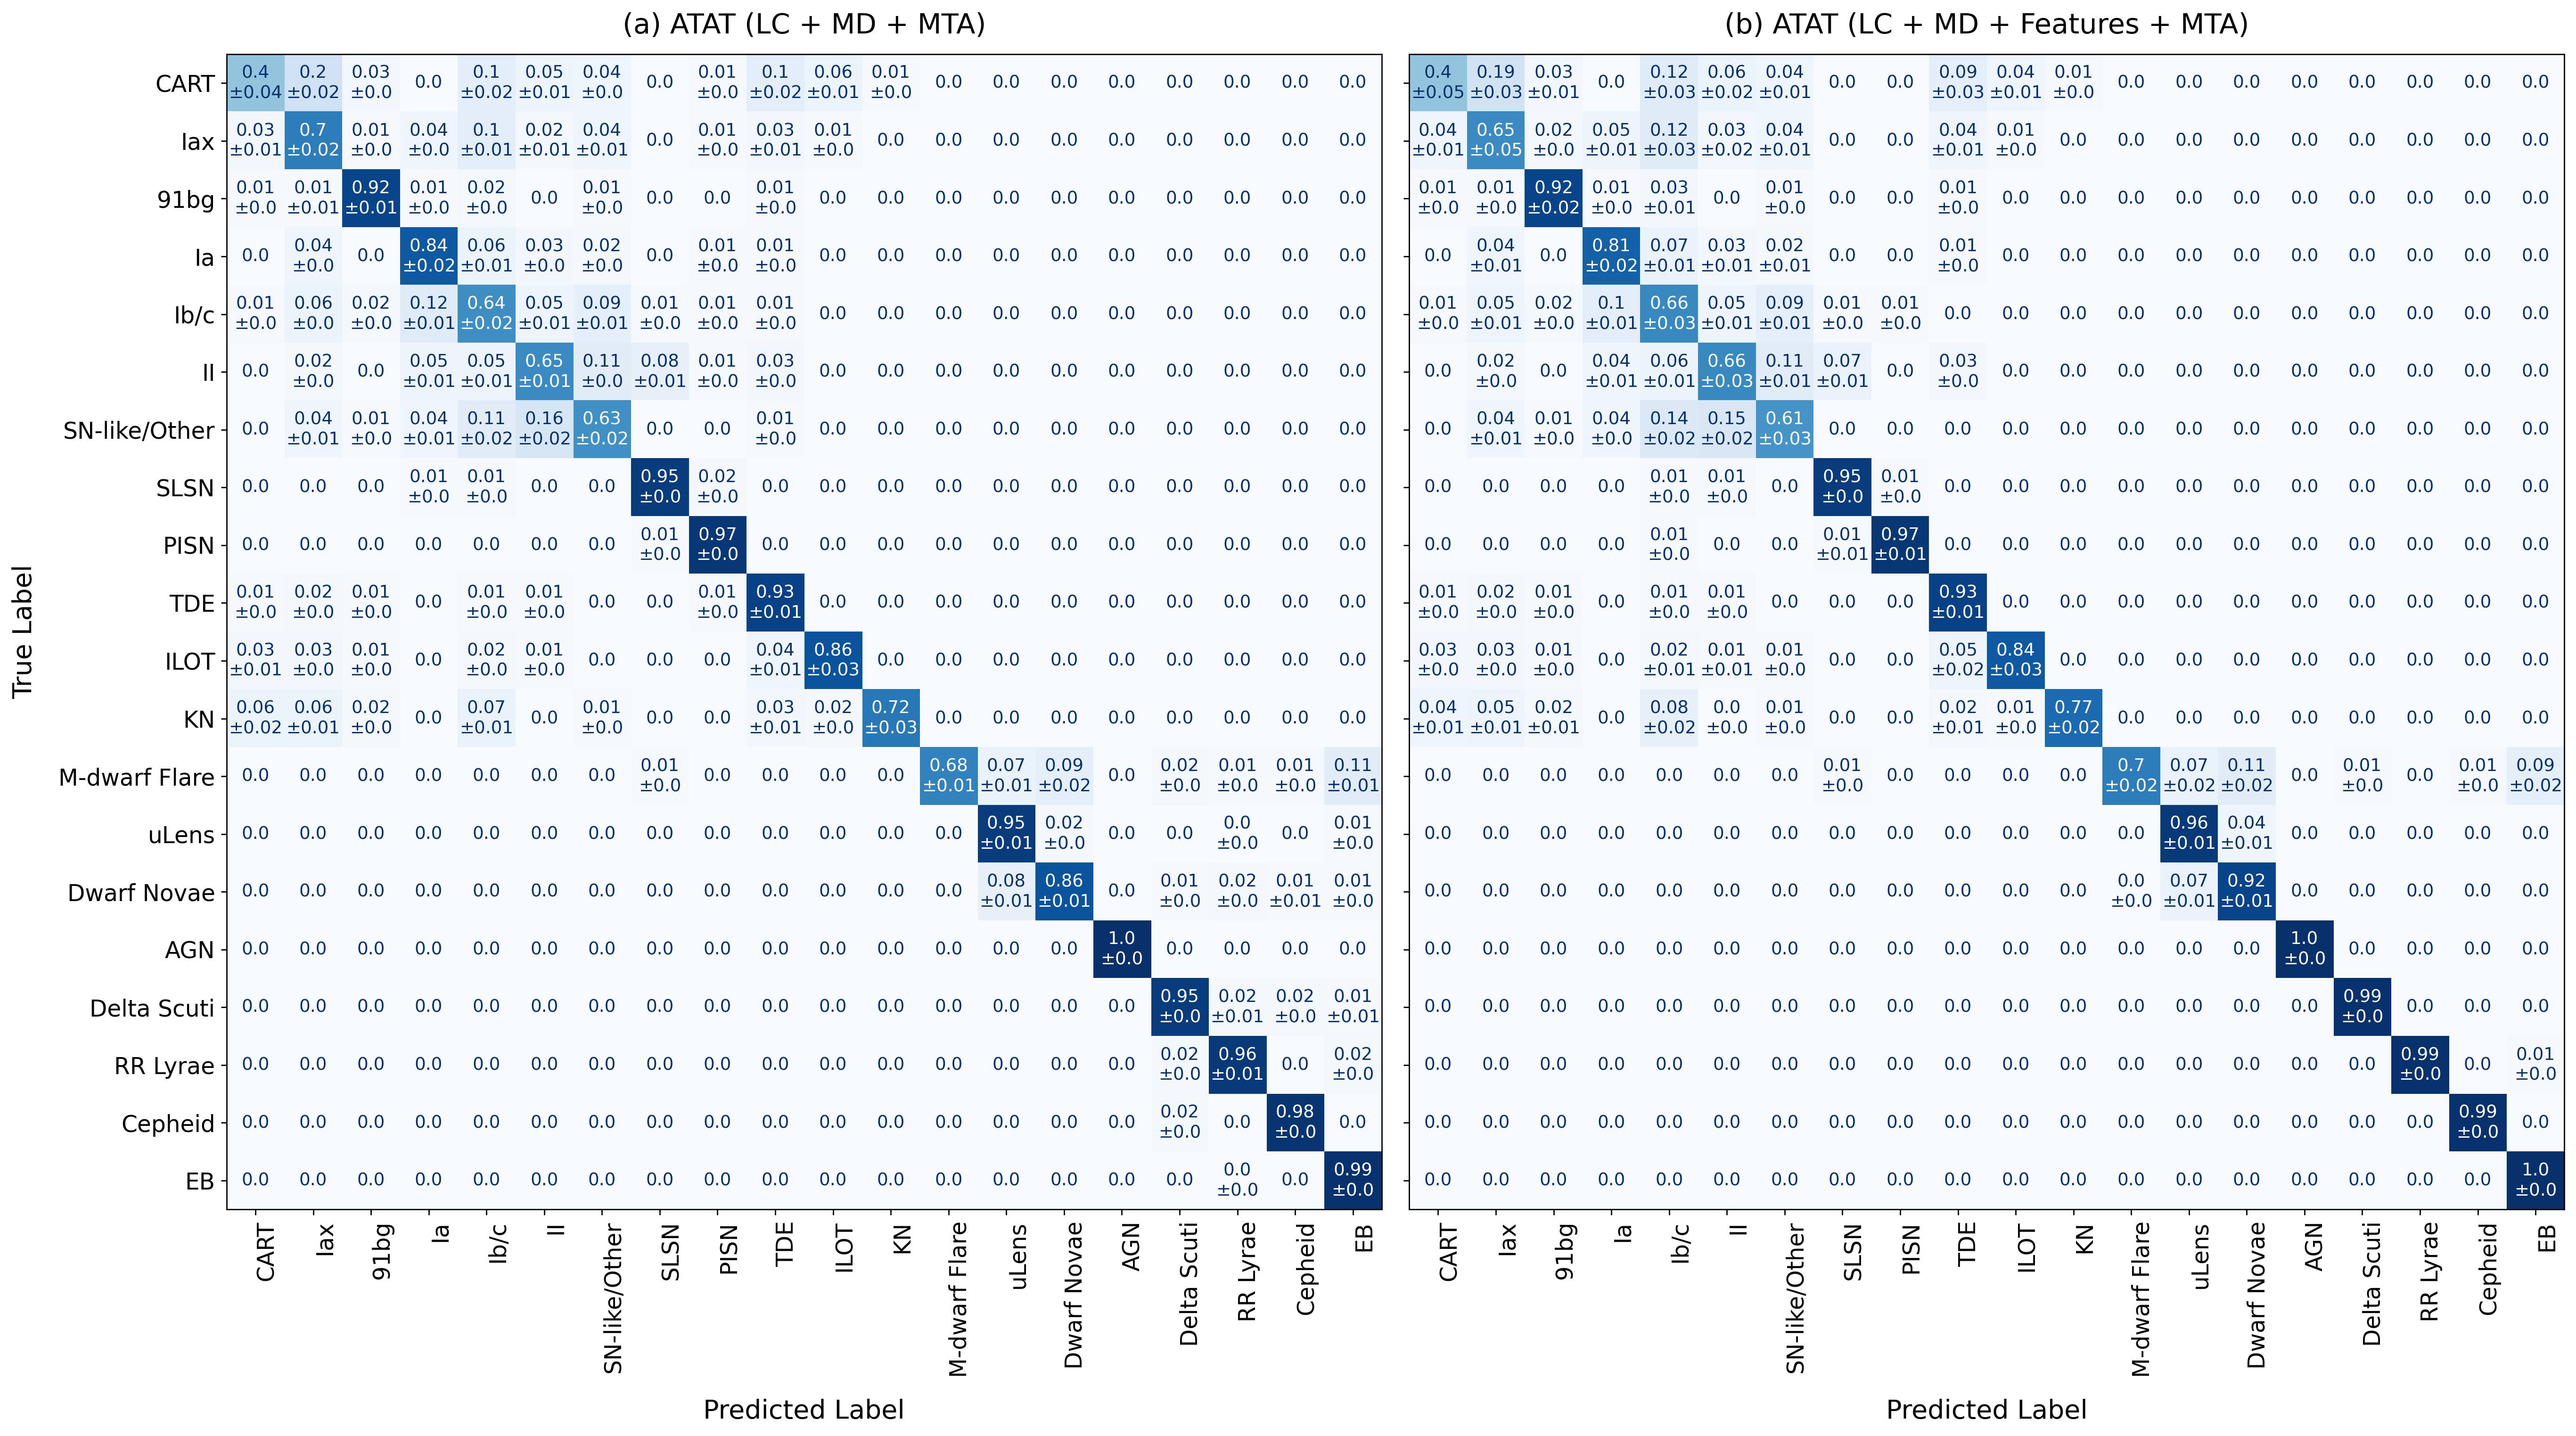

In [89]:
# Graficando la matriz media
cmap = plt.cm.Blues
#fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
fig, axes = plt.subplots(1, 2, figsize=(22, 22), sharey=True, dpi=250)

titles = ['(a) ATAT (LC + MD + MTA)', '(b) ATAT (LC + MD + Features + MTA)']
mean_matrices_col = [mean_matrix_lc_md, mean_matrix_lc_md_feat]
std_matrices_col = [std_matrix_lc_md, std_matrix_lc_md_feat]

for cont, (ax, mean_matrix, std_matrix) in enumerate(zip(axes, mean_matrices_col, std_matrices_col)):
    im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrix[i, j] >= 0.005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    ax.set_title(titles[cont], fontsize=17, pad=13)
    ax.set_xlabel('Predicted Label', fontsize=16)

    if cont == 0:
        ax.set_ylabel('True Label', fontsize=16)

plt.tight_layout()
#os.makedirs('images', exist_ok=True)
#plt.savefig("./images/cm_ATAT.pdf", format="pdf", bbox_inches="tight")
plt.show()

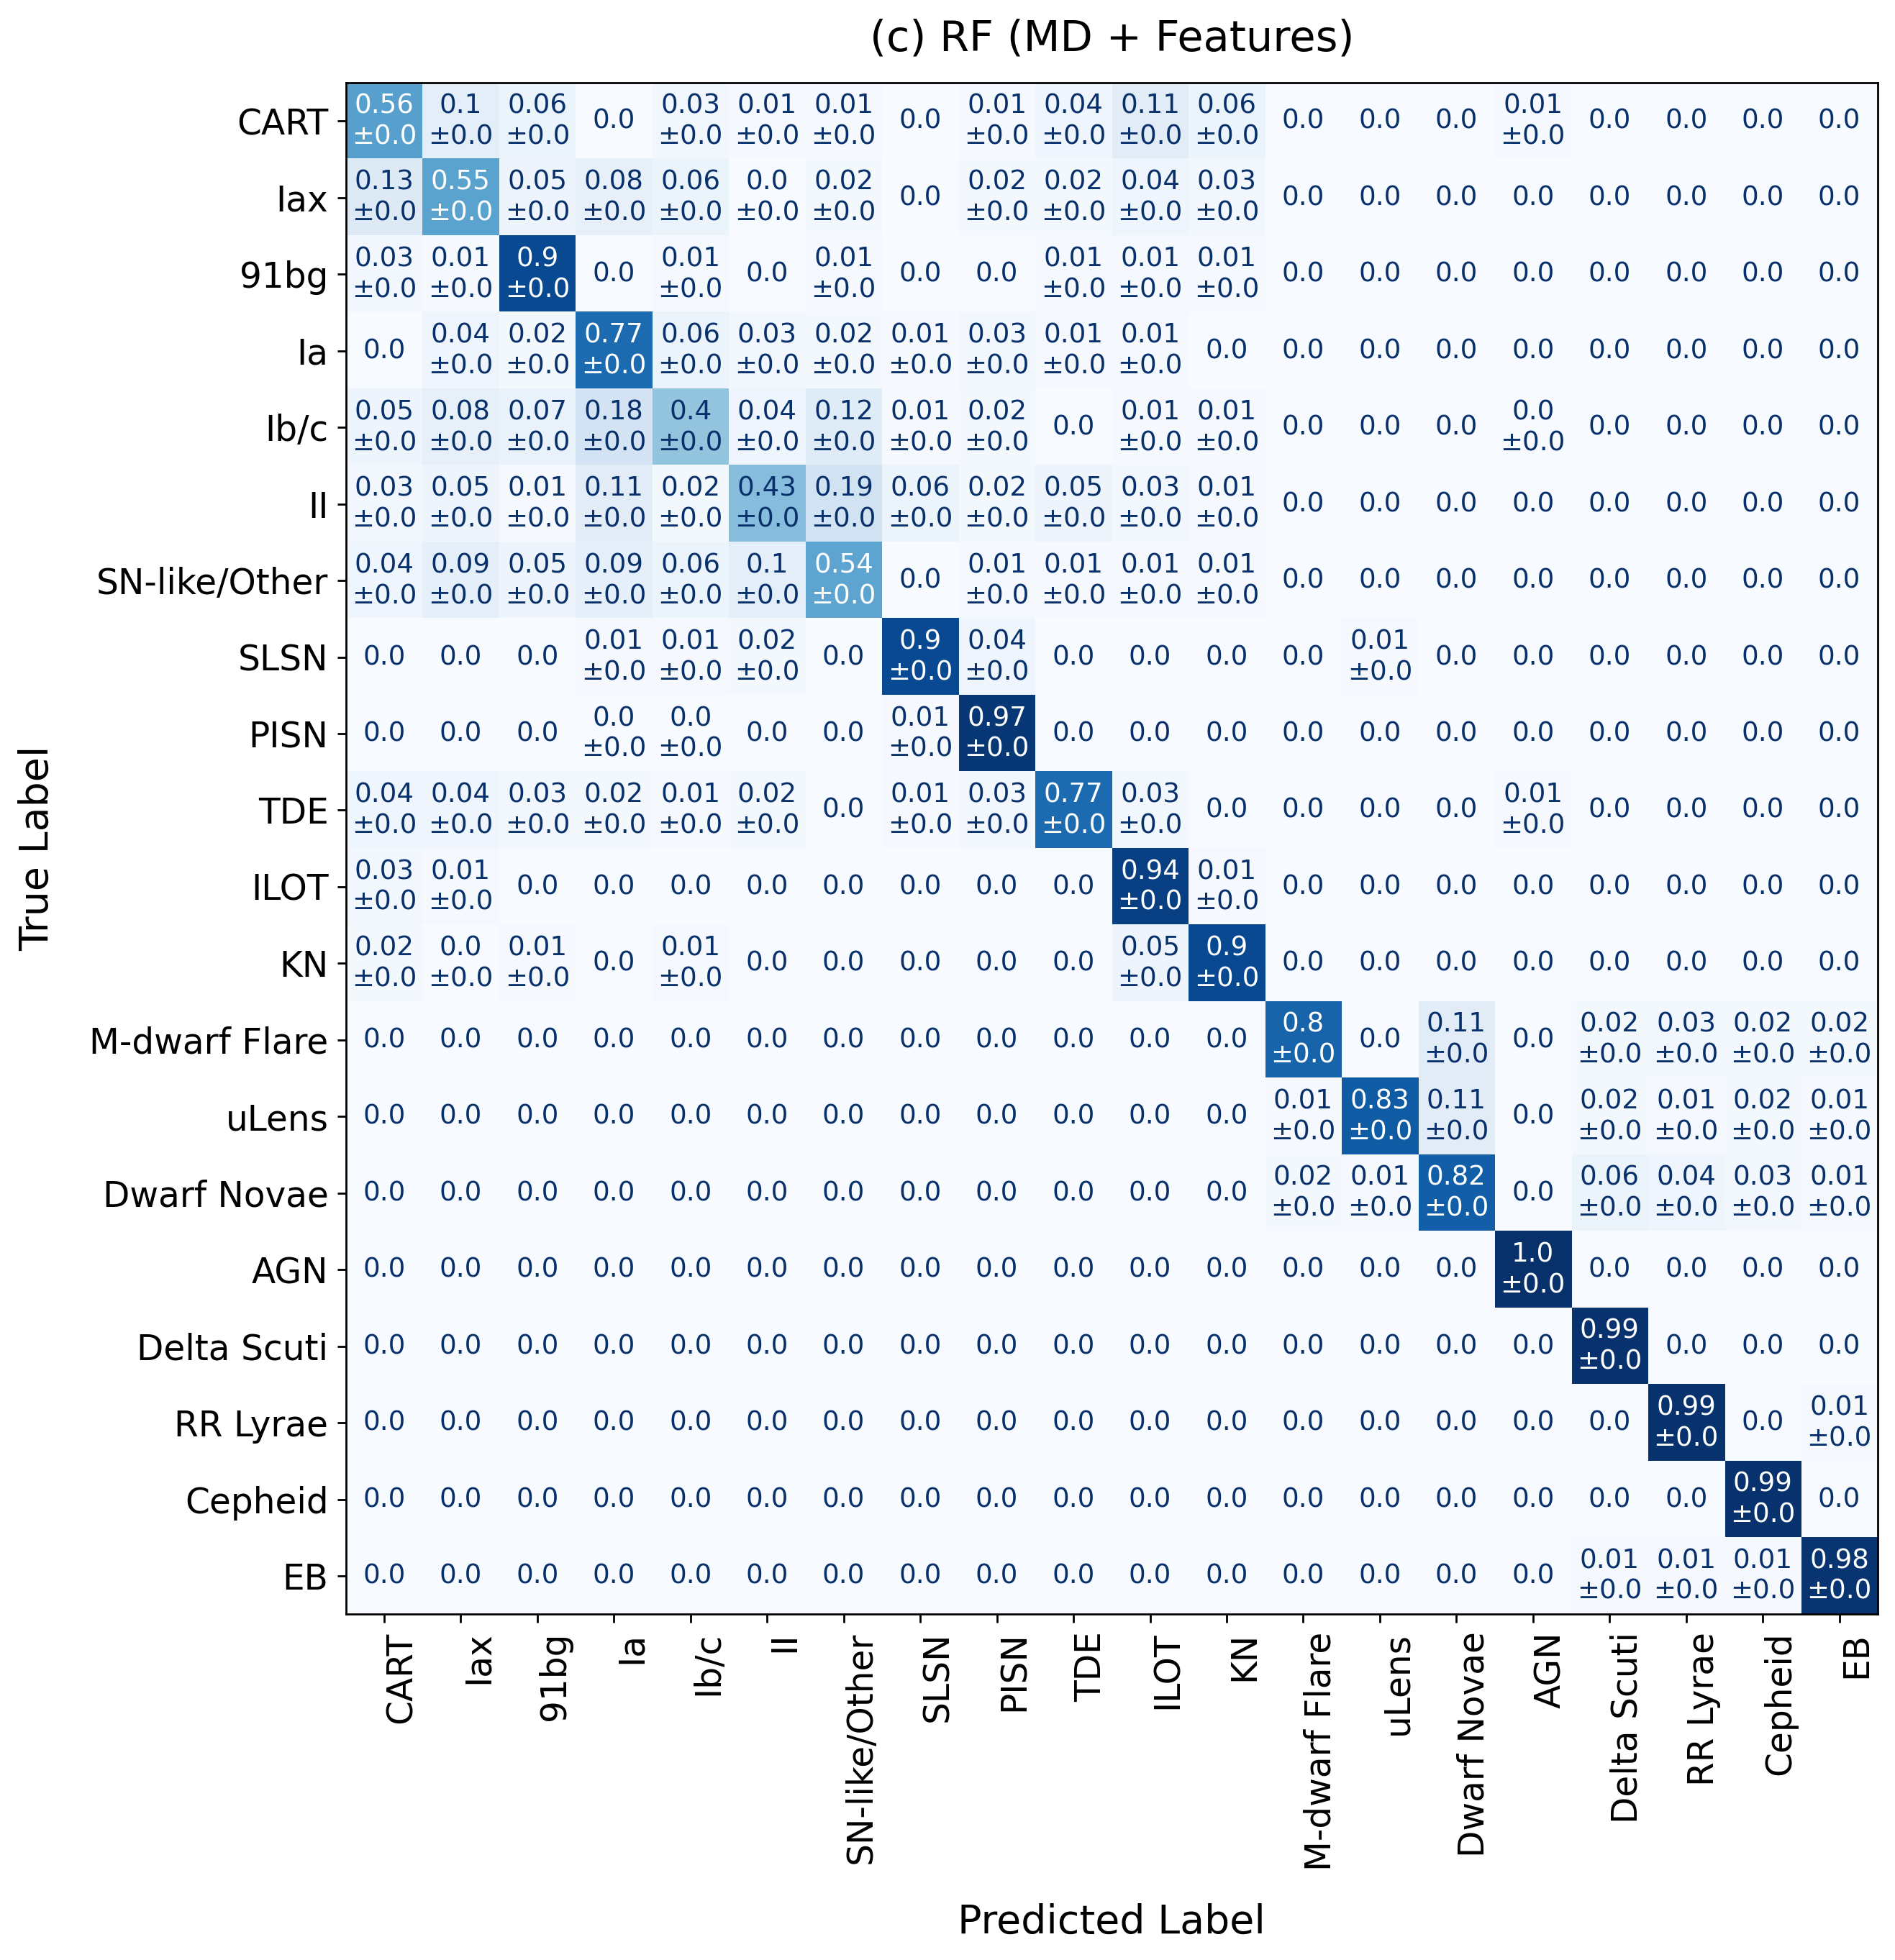

In [90]:
title = '(c) RF (MD + Features)'

# Graficando la matriz media
cmap = plt.cm.Blues
#fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
fig, ax = plt.subplots(1, 1, figsize=(11, 11), sharey=True, dpi=250)

im = ax.imshow(np.around(mean_matrix_rf, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(mean_matrix_rf.shape[0]):
    for j in range(mean_matrix_rf.shape[1]):
        if mean_matrix_rf[i, j] >= 0.005:
            #print(mean_matrix_rf[i, j])
            text = f'{np.around(mean_matrix_rf[i, j], decimals=2)}\n±{np.around(std_matrix_rf[i, j], decimals=2)}'
            color = "white" if mean_matrix_rf[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)
        else:
            text = f'{np.around(mean_matrix_rf[i, j], decimals=2)}'
            color = "white" if mean_matrix_rf[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

ax.set_title(title, fontsize=17, pad=13)
ax.set_xlabel('Predicted Label', fontsize=16)
ax.set_ylabel('True Label', fontsize=16)

plt.tight_layout()
#os.makedirs('images', exist_ok=True)
#plt.savefig("./images/cm_rf.pdf", format="pdf", bbox_inches="tight")
plt.show()